## Outlier Engineering 

* An outlier is a data point which is significantly different from the remaining data 
* "An outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism." [D. Hawkins. Identification of Outliers, Chapman and Hall, 1980]
* Algorithms susceptiable to outliers: Linear models, Adaboost. 
* Outliers should be detected and removed **ONLY** from the training set, and NOT from test set. 
* Ways to engineer outliers 
  * Trimming 
    * Removing outliers from the data set
    * Pros: Fast. 
    * Cons: Can remove big chunk of data 
  * Missing data
    * Treat outliers as missing data and perform missing data imputation 
  * Discretisation
    * Put outliers into lower/upper bins
  * Censoring 
    * Capping = maximum/minimum allowed value and replace outliers with it
    * Pro: No data is removed
    * Con: Distorts variable distribution 

* Detectin Outliers 
  * Gaussian distribution (mean and std)
  * Inter-quantal range proximity rule
  * Qantiles 
* Normal distribution
  * 99% of the observations of a normally distributed variable lie within the mean +- 3 standard deviation --> values outside of mean +- 3 std are considered outliers 
  * Or 95% of the observations above the 5th quantile, vice versa. --> Values above or below the 95th or 5th quantile are considered outliers
* Skewed distributions
  * The general approach is to calculate the quantiles, and then the inter-quantile range (IQR), as follows: 
  * IQR = 75th quantile - 25th quantile 
  * Upper limit = 75th quantile + IQR X 1.5
  * Lower limit = 25th quantile - IQR X 1.5
  * For extreme outliers, multiply the IQR nby 3 instead of 1.5

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.datasets import load_boston

In [2]:
# load data
data = load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)[['RM', 'LSTAT', 'CRIM']]

In [3]:
df

,RM,LSTAT,CRIM
0,6.575,4.98,0.00632
1,6.421,9.14,0.02731
2,7.185,4.03,0.02729
3,6.998,2.94,0.03237
4,7.147,5.33,0.06905
...,...,...,...
501,6.593,9.67,0.06263
502,6.120,9.08,0.04527
503,6.976,5.64,0.06076
504,6.794,6.48,0.10959


# 0. Original distribution

In [4]:
def diagnostic_plots(df, variable):
    fig, ax = plt.subplots(figsize=(15, 5))
    
    # histogram 
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')
    
    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist='norm', plot=plt)
    plt.ylabel('Quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y = df[variable])
    plt.title('Boxplot')

    plt.show()

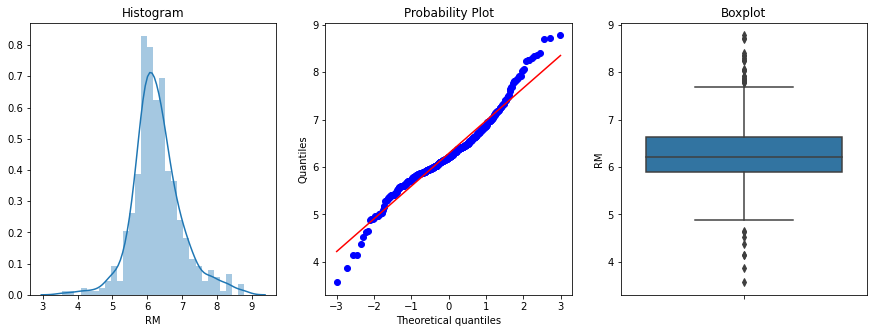

In [5]:
diagnostic_plots(df, 'RM')

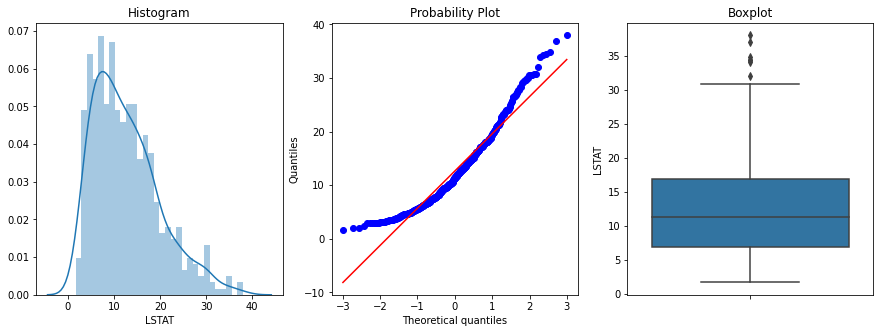

In [6]:
diagnostic_plots(df, 'LSTAT')

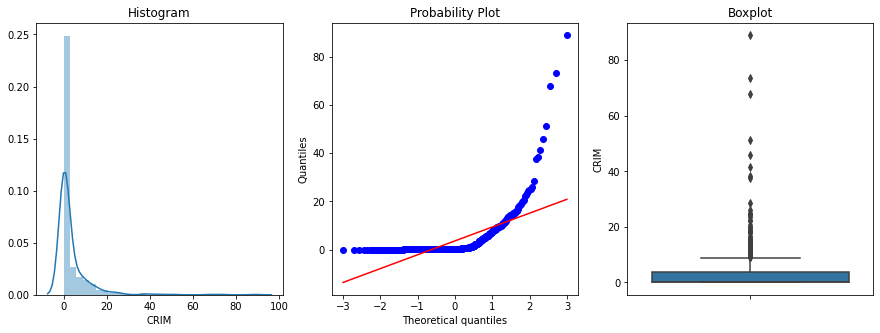

In [7]:
diagnostic_plots(df, 'CRIM')

# 1. Trimming

In [8]:
# Find upper and lower boundary 
def find_skewed_boundaries(df, variable, distance):
    # distance is normally 1.5 or 3
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
  
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
  
    return upper_boundary, lower_boundary

In [9]:
boundary = {}
for variable in df.columns:
    upper_boundary, lower_boundary = find_skewed_boundaries(df, variable, distance=1.5)
    boundary[variable] = {'upper_boundary': upper_boundary, 'lower_boundary': lower_boundary}


In [10]:
boundary

{'RM': {'upper_boundary': 7.730499999999999,
  'lower_boundary': 4.778500000000001},
 'LSTAT': {'upper_boundary': 31.962500000000006,
  'lower_boundary': -8.057500000000005},
 'CRIM': {'upper_boundary': 9.06963875, 'lower_boundary': -5.31051125}}

In [11]:
# Flag outliers 
def flag_outliers(df, variable, boundary_dict):
    outliers = np.where(df[variable] > boundary.get('upper_boundary'), True,
                        np.where(df[variable] < boundary.get('lower_boundary'), True, False))
    return outliers 

outliers_RM = flag_outliers(df, 'RM', boundary.get('RM'))
outliers_LSTAT = flag_outliers(df, 'LSTAT', boundary.get('LSTAT'))
outliers_CRIM = flag_outliers(df, 'CRIM', boundary.get('CRIM'))

In [12]:
# Remove outliers
df_trimmed = df.loc[~(outliers_RM + outliers_LSTAT + outliers_CRIM), :]

In [13]:
df.shape, df_trimmed.shape

((506, 3), (506, 3))

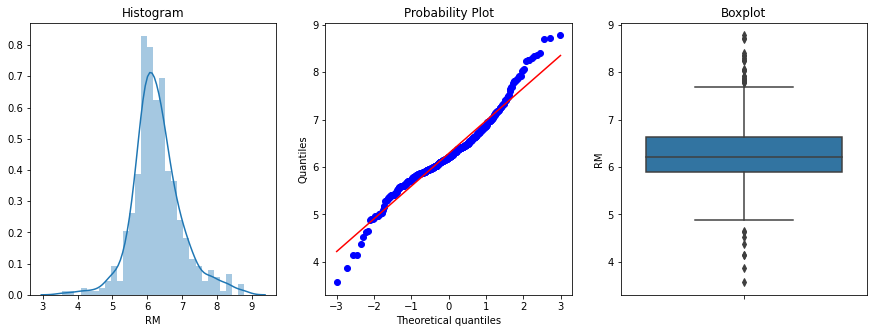

In [14]:
diagnostic_plots(df_trimmed, 'RM')

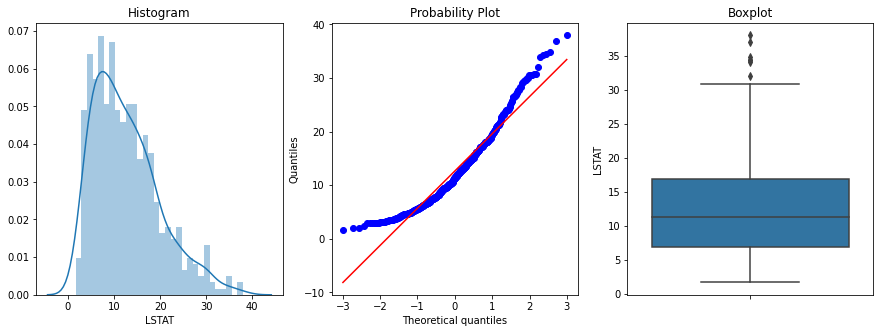

In [15]:
diagnostic_plots(df_trimmed, 'LSTAT')

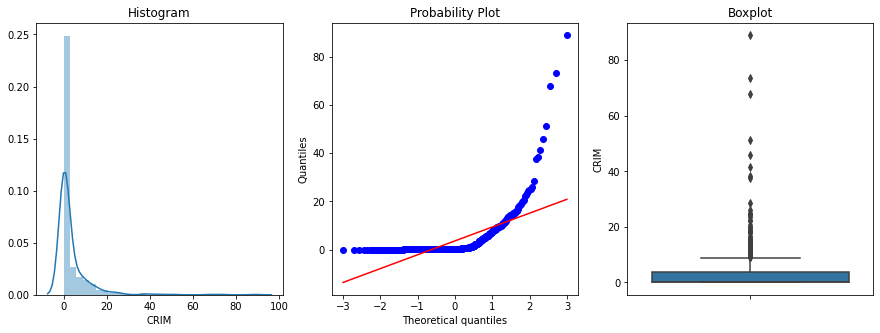

In [16]:
diagnostic_plots(df_trimmed, 'CRIM')

# 2. Cencoring or capping

In [17]:
df_capped = df.copy()

def cap_extreme(df, variable, boundary_dict): 
    upper_boundary = boundary_dict.get('upper_boundary')
    lower_boundary = boundary_dict.get('lower_boundary')
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                            np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))
    return df

df_capped = cap_extreme(df_capped, 'RM', boundary.get('RM'))
df_capped = cap_extreme(df_capped, 'LSTAT', boundary.get('LSTAT'))
df_capped = cap_extreme(df_capped, 'CRIM', boundary.get('CRIM'))

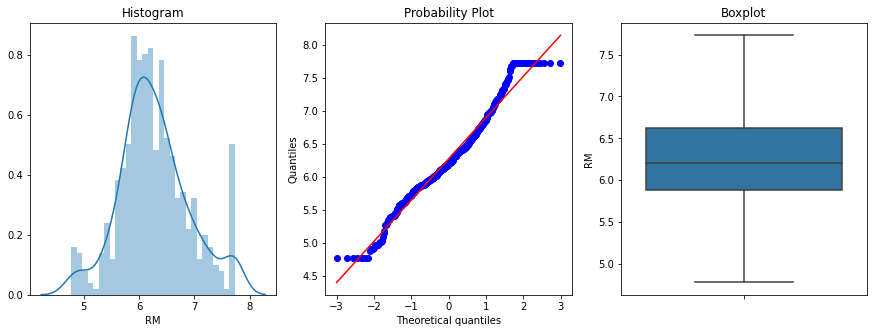

In [18]:
diagnostic_plots(df_capped, 'RM')

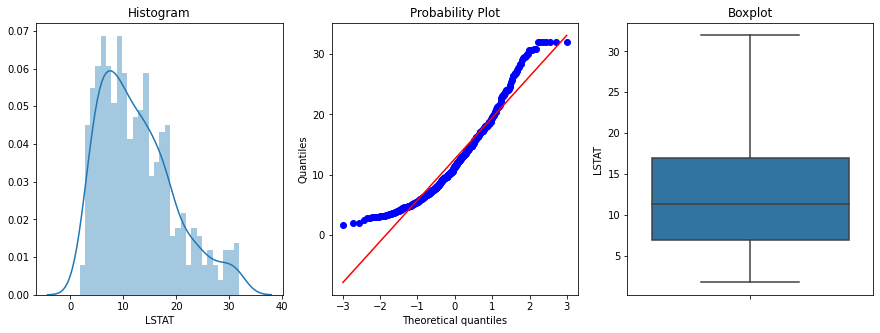

In [19]:
diagnostic_plots(df_capped, 'LSTAT')

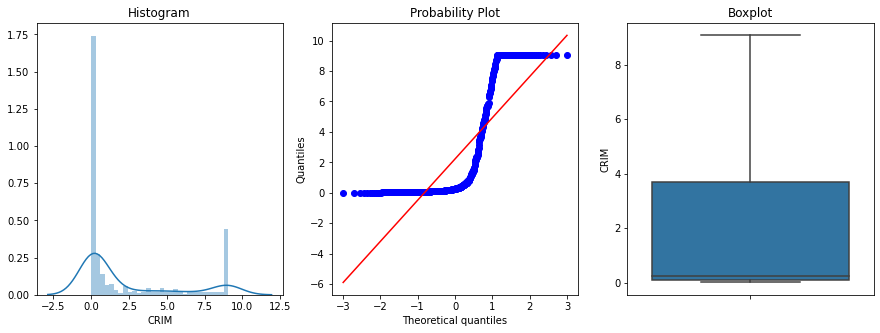

In [20]:
diagnostic_plots(df_capped, 'CRIM')

# 3. Outlier capping with mean and std

In [21]:
def find_normal_boundaries(df, variable, distance=3):
    upper_boundary = df[variable].mean() + distance * df[variable].std()
    lower_boundary = df[variable].mean() - distance * df[variable].std()
  
    return upper_boundary, lower_boundary

# find boundaries 
boundary = {}
for variable in df.columns:
    upper_boundary, lower_boundary = find_normal_boundaries(df, variable, distance=3)
    boundary[variable] = {'upper_boundary': upper_boundary, 'lower_boundary': lower_boundary}


In [22]:
def cap_with_normal_boudary(df, variable, boundary):
    upper_limit = boundary.get('upper_boundary')
    lower_limit = boundary.get('lower_boundary')
    
    df[variable] = np.where(df[variable] > upper_limit, upper_limit, 
                            np.where(df[variable] < lower_limit, lower_limit, df[variable]))
    return df
    
# replace values 
df_normal_capped = df.copy()
df_normal_capped = cap_with_normal_boudary(df_normal_capped, 'RM', boundary.get('RM'))
df_normal_capped = cap_with_normal_boudary(df_normal_capped, 'LSTAT', boundary.get('LSTAT'))
df_normal_capped = cap_with_normal_boudary(df_normal_capped, 'CRIM', boundary.get('CRIM'))

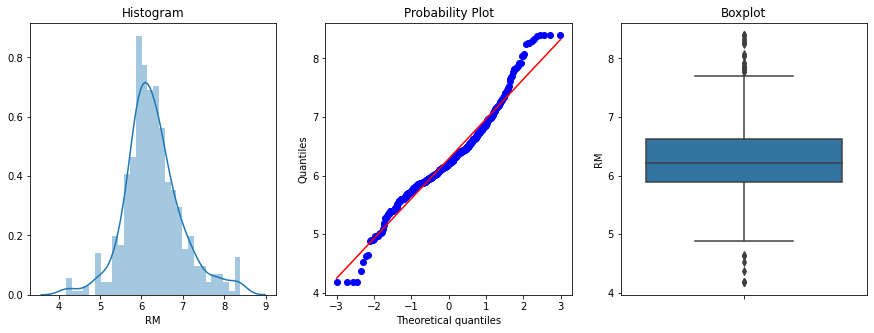

In [23]:
diagnostic_plots(df_normal_capped, 'RM')

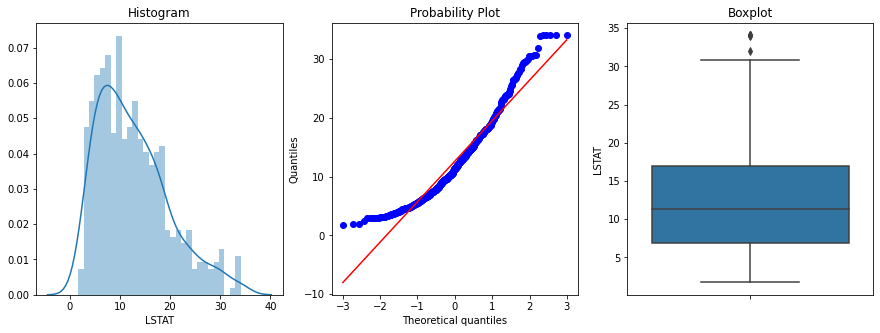

In [24]:
diagnostic_plots(df_normal_capped, 'LSTAT')

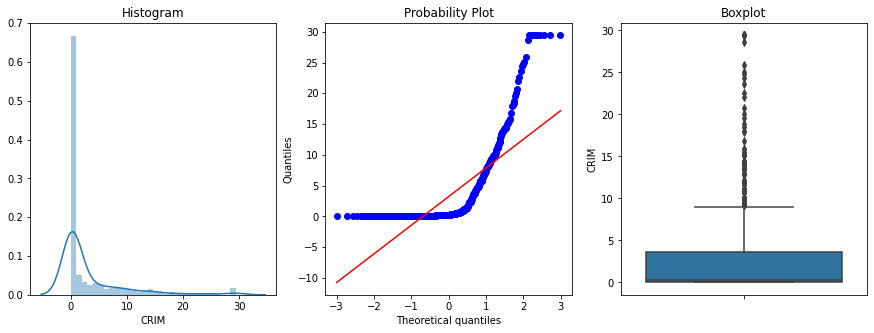

In [25]:
diagnostic_plots(df_normal_capped, 'CRIM')

# 4. Outlier capping with quantile

In [26]:
def find_quant_boundaries(df, variable):
    upper_boundary = df[variable].quantile(0.95)
    lower_boundary = df[variable].quantile(0.05)
  
    return upper_boundary, lower_boundary

# find boundaries 
boundary = {}
for variable in df.columns:
    upper_boundary, lower_boundary = find_quant_boundaries(df, variable)
    boundary[variable] = {'upper_boundary': upper_boundary, 'lower_boundary': lower_boundary}


In [27]:
boundary

{'RM': {'upper_boundary': 7.5875, 'lower_boundary': 5.314},
 'LSTAT': {'upper_boundary': 26.8075, 'lower_boundary': 3.7075000000000005},
 'CRIM': {'upper_boundary': 15.78915, 'lower_boundary': 0.027909999999999997}}

In [28]:
def cap_with_quant_boundary(df, variable, boundary):
    upper_limit = boundary.get('upper_boundary')
    lower_limit = boundary.get('lower_boundary')
    
    df[variable] = np.where(df[variable] > upper_limit, upper_limit, 
                            np.where(df[variable] < lower_limit, lower_limit, df[variable]))
    return df
    
# replace values 
df_quant_capped = df.copy()
df_quant_capped = cap_with_quant_boundary(df_quant_capped, 'RM', boundary.get('RM'))
df_quant_capped = cap_with_quant_boundary(df_quant_capped, 'LSTAT', boundary.get('LSTAT'))
df_quant_capped = cap_with_quant_boundary(df_quant_capped, 'CRIM', boundary.get('CRIM'))

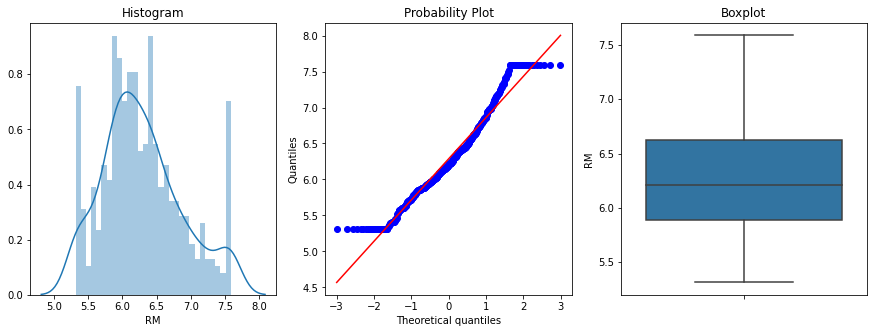

In [29]:
diagnostic_plots(df_quant_capped, 'RM')

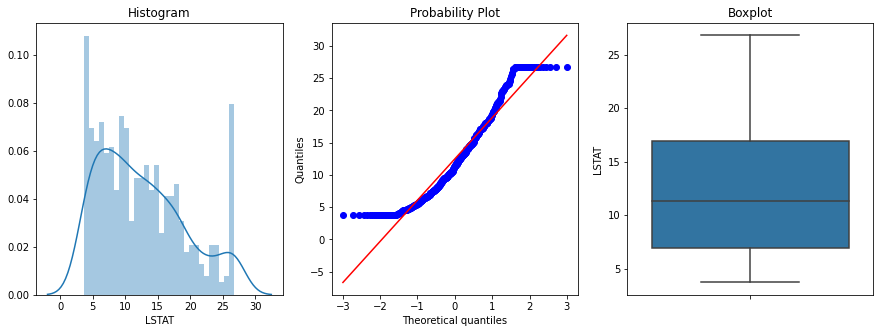

In [30]:
diagnostic_plots(df_quant_capped, 'LSTAT')

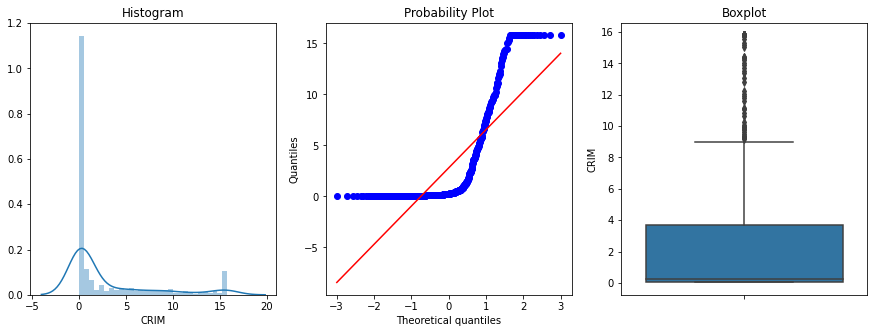

In [31]:
diagnostic_plots(df_quant_capped, 'CRIM')